# Example: Quantum Convolutional Neural Network

In this notebook we show how to use the `QCNN encoding circuit` for classification.

## Imports

In [12]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from squlearn.encoding_circuit.circuit_library.param_z_feature_map import ParamZFeatureMap
from squlearn.encoding_circuit.layered_encoding_circuit import LayeredEncodingCircuit
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam
from qiskit_algorithms.optimizers import *
from squlearn import Executor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qcnn_encoding_circuit import QCNNEncodingCircuit

In [13]:

# Function to read and process data from the input format
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    features = []
    labels = []

    i = 0
    while i < 1000:
        num_atoms = int(lines[i])
        energy = float(lines[i + 1].split()[-1])
        label = np.array([energy])

        atom_data = [line.split() for line in lines[i + 2:i + 2 + num_atoms]]
        coordinates = np.array([[float(coord) for coord in atom[1:]] for atom in atom_data])

        features.append(coordinates.flatten())
        labels.append(label)

        i += 2 + num_atoms

    return np.array(features), np.array(labels)


# Read data from the provided file
file_path = 'water-DZ-F12-STATIC-g32n10-3M_PES-DZERO.xyz'
features, labels = read_data(file_path)
print(features[:3], labels[:3])
print(len(features), len(labels))

[[ 0.0089378   0.          0.43550962 -0.79730093  0.         -0.59766049
   0.6554516   0.         -0.48758562]
 [ 0.00715024  0.          0.43550962 -0.78311599  0.         -0.586653
   0.66963653  0.         -0.49859311]
 [-0.02323827  0.          0.43812567 -0.57271362  0.         -0.42028506
   0.94152185  0.         -0.70647973]] [[-76.27315556]
 [-76.27389312]
 [-76.2506881 ]]
200 200


In [14]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

features = MinMaxScaler().fit_transform(features)

train_labelm = np.mean(labels)
train_labelstd = np.std(labels)

print("Mean = ", train_labelm, "Std =", train_labelstd)

transformed_labels = (labels - train_labelm) / train_labelstd
print(len(transformed_labels))
print(transformed_labels[1])
print(features[1])

test_size=0.2
train_features, test_features, train_labels, test_labels = train_test_split(
    features, transformed_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


Mean =  -76.05919540290999 Std = 0.093825628147694
200
[-2.28826305]
[0.625      0.         0.88480711 0.18156391 0.         0.25814234
 0.68614404 0.         0.44156504]


## `QCNN encoding circuit` Setup

We start by showing examples of how to build the QCNN. The first example is the most simple way. With the `default` keyword set to "True" the default circuit with the given number of qubits and features is build.

c:\Users\rotht\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


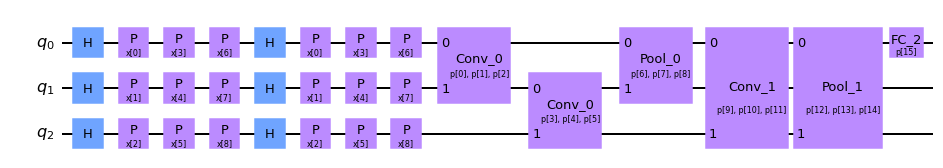

In [15]:
qc1 = QCNNEncodingCircuit(num_qubits=3, num_features=9, default=True)
qc1.draw("mpl")

Another fast way would be to define a convolution layer and a pooling layer and call the `repeat_layers` function to repeat the first layers until few enough qubits are left in the circuit. The individual building blocks can be resolved with the keyword `decompose`.

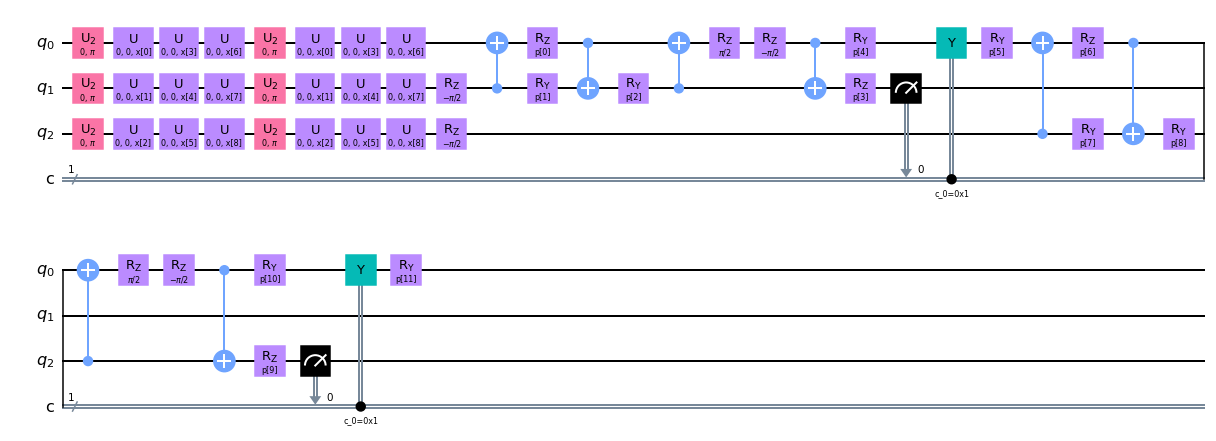

In [16]:
qc1 = QCNNEncodingCircuit(3, 9)
qc1.convolution(alternating=False)
qc1.pooling(measurement=True)
qc1.repeat_layers()
qc1.draw("mpl", decompose=True)

We can provide our own feature map and add it in front of the encoding circuit. Further we can change the number of qubits and features in the circuit on the fly `up` (and `down`, if the already applied pooling gates allow it).

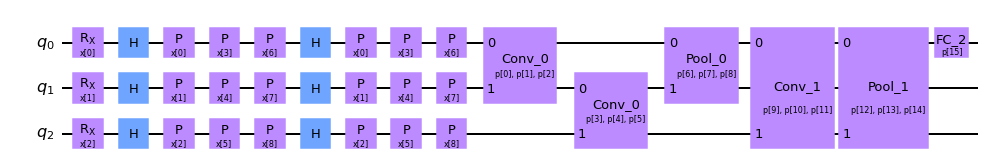

In [17]:
qc1 = QCNNEncodingCircuit(num_qubits=3, default=True)
qc1.set_params(num_qubits=3, num_features=9)
encode = LayeredEncodingCircuit.from_string("Rx(x)", num_qubits=3, num_features=9)
qcnn_pqc = encode + qc1
qcnn_pqc.draw("mpl")

We can overwrite the default circuits in the given layer by setting the keyword `quantum_circuit`. The Circuits can either be `QuantumCircuit` or `sQUlearn circuit` objects (if one inputs a circuit with features as in "ParamZFeatureMap" a warning is shown). The circuit size is only restricted by the number of qubits left in the qcnn. In the pooling layer the adressed qubits can be set with the keywords `input_list` and `output_list`.

Features are set to 1 since no features are allowed in the QCNN ansatz.
The sublists in the input list either adress the same  qubit or qubits which are not in the current circuit.


c:\Users\rotht\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit\circuit\quantumcircuit.py:1807: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


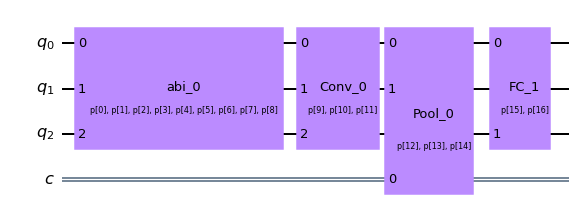

In [18]:
qc1 = QCNNEncodingCircuit(3)

qc2 = ParamZFeatureMap(3, 9, 1)

x1 = ParameterVector("x", 2)
qc3 = QuantumCircuit(2)
qc3.crx(x1[0], 0, 1)
qc3.rx(x1[1], 0)

x2 = ParameterVector("x", 3)
qc4 = QuantumCircuit(3)
qc4.rx(x2[0], 0)
qc4.rx(x2[1], 1)
qc4.rx(x2[2], 2)
qc4.cx(0, 1)
qc4.cx(1, 2)

qc1.convolution(quantum_circuit=qc2, label="abi", alternating=False, diff_params=False)
qc1.pooling(quantum_circuit=qc3, input_list=[[0, 2], [1, 4]], output_list=[[2], [1]])
qc1.convolution(quantum_circuit=qc4)
qc1.pooling(measurement=True)
qc1.fully_connected()
qc1.draw("mpl")

Finally we can build the circuit "backwards" by supplying the gates first and then how many qubits should be in the output and you can even continue building from there forward if no fully connected layer is applied.

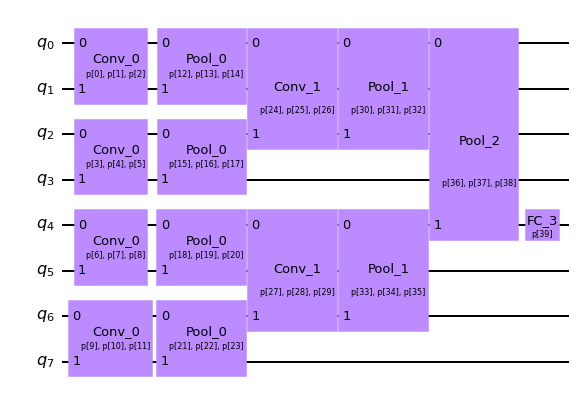

In [19]:
qc1 = QCNNEncodingCircuit()
qc1.convolution(alternating=False)
qc1.pooling()
qc1.repeat_layers(1)
qc1.build_circuit(2)
qc1.pooling(input_list=[[0, 4]], output_list=[[4]])
qc1.fully_connected()
qc1.draw("mpl")

The fitting default observable for the circuit can be extracted once finished with building the circuit. Notice that the observable "IIIIIZ" corresponds to only measuring the first qubit "q0".

In [20]:
ob = qc1.QCNNObservable(pauli="Z")
print(ob)

SparsePauliOp(['IIIIIIII', 'IIIZIIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1])])


In the following we creat training and test data. This is not supposed to be a senceful usecase of qcnn structures but to show how to properly work with this encoding circuit in the sQUlearn environment.

In [10]:
# Data that is inputted to the QNN
X = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y = np.square(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

Next the encoding circuit and observable are build.

SparsePauliOp(['III', 'IIZ'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1])])


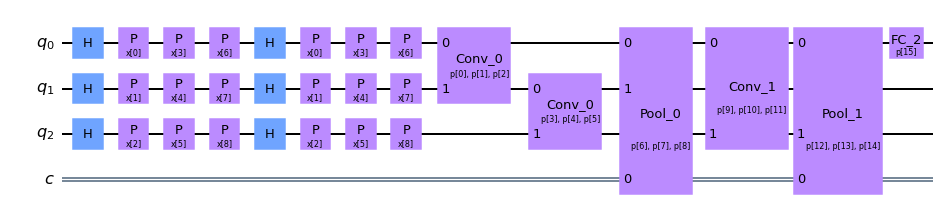

In [21]:
qc = QCNNEncodingCircuit(3, 9)
qc.convolution()
qc.pooling(measurement=True)
qc.repeat_layers()
qc.fully_connected()

ob = qc.QCNNObservable()
print(ob)
qc.draw("mpl")

In [22]:
def callback_graph(obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Now we can set up the Regressor and train it. Notice that if one sets `measurement` to "True", one needs to use a sampler executor like "qasm_simulator".

In [23]:
qnn = QNNRegressor(
    qc,
    ob,
    Executor("qasm_simulator"),
    SquaredLoss(),
    Adam(options={"maxiter": 10}),
    callback=callback_graph,
    param_ini=[
        -0.2696767275313419,
        0.4934284929034265,
        -0.250998034867262,
        1.8757640255145007,
        -0.7133460992759717,
        0.6309096880117444,
        -0.2852599584462533,
        2.816036742146686,
        2.4931113727968297,
        -1.0664294358424289,
        2.0874188489413386,
        -0.3592461154094,
        0.4310484058337916,
        2.3792622131513177,
        -3.032215760747041,
        -2.5776863597181165,
        -2.563770353234295,
        2.510467277762751,
        1.7837807707704727,
        2.0171684238605176,
        3.1433028463386883,
        2.3830216072023194,
        -0.547564432656872,
        1.455152484409271,
        -2.5917449781263437,
    ],
    param_op_ini=[0.7418021705585677, 1.0085108175066573],
)


In [28]:
qnn = QNNRegressor(
    qc,
    ob,
    Executor("qasm_simulator"),
    SquaredLoss(),
    Adam(options={"maxiter": 100}),
    callback=callback_graph,
)


In [30]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

qnn.fit(train_features, train_labels)

ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

Finally we can plot the results of the classification.

Optimal gate parameters:
[
-0.3290590843433438,
0.057489357877602065,
-0.34361028801505195,
1.9400939172383653,
-0.6404894728748621,
0.6718158417272202,
-0.1824969205082959,
2.865491228821335,
2.5183223146334477,
-1.0042561563872878,
2.0363459001269253,
-0.35532268270665157,
0.5831696766544354,
2.377078150404173,
-3.030478521505635,
-2.281328571789093,
-2.5631261632748013,
2.493823054725825,
1.8808657483136972,
2.2143462356274495,
3.2980555550069797,
2.516723906716394,
-0.39466781096122433,
1.6546659758062565,
-2.551329791471711,
]
--------------
Optimal observable parameters:
[
0.7407316300848844,
0.9800537902869514,
]
sigma train:  0.1966032527671615 , sigma test:  0.12209944231758765


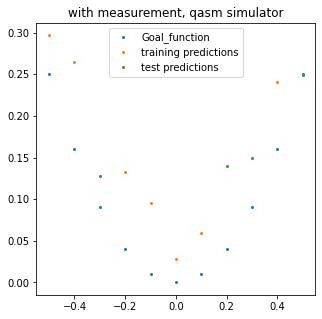

In [ ]:
# ouput optimal parameters
print("Optimal gate parameters:")
print("[")
for i in qnn.param:
    print(str(i) + ",")
print("]")
print("--------------")
print("Optimal observable parameters:")
print("[")
for i in qnn.param_op:
    print(str(i) + ",")
print("]")

y_train_predict = qnn.predict(X_train)
y_test_predict = qnn.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("with measurement, qasm simulator")
ax.plot(X, y, label="Goal_function", markersize=2, marker="o", linestyle="None")
ax.plot(
    X_train,
    y_train_predict,
    label="training predictions",
    markersize=2,
    marker="o",
    linestyle="None",
)
ax.plot(
    X_test, y_test_predict, label="test predictions", markersize=2, marker="o", linestyle="None"
)
ax.legend()

sigma_train = np.sqrt(np.sum(np.square(y_train_predict - y_train)))
sigma_test = np.sqrt(np.sum(np.square(y_test_predict - y_test)))
print("sigma train: ", sigma_train, ", sigma test: ", sigma_test)